# Scaling of the maximum energy vs the number of virtual orbitals for $N_2$ with pbc

We consider a $N_2$ molecule and we determine the maximum energy, that is the energy of the last virtual orbital in function of the number of virtual orbitals.

In [1]:
#%autosave 0
from BigDFT import Logfiles as lf
from futile import Yaml
import matplotlib.pyplot as plt
import numpy as np
inputpath = 'testfiles/N2maxEngVorb/input-pbc/'

## Analysis for rmult =[7.0, 9.0]

First of all we define the python dictionary that contains the basic keys common to all the file in the run.  We use pbc using the same box built for rmult=7 in the free buondary condition.

In [2]:
inp0 = {'dft' : 
        {'hgrids': 0.4,
         'rmult': [7.0, 9.0],
         'gnrm_cv' : 1e-8,
         'itermax' :100},
        'radical': 'N2_rmult7-pbc', #always in the same directory
        'posinp': 'N2_posinp_rmult7-pbc.xyz'}

and we write these common variables in the default file:

In [3]:
Yaml.dump(inp0,inputpath + 'default.yaml')

Then we write a list of input file with increasing number of virtual orbitals

In [4]:
norb=[16,32,64,128,256]

In [5]:
for n in norb:
    inp={'dft':{'norbv': -n}}
    inp = {'dft' : 
        {'norbv': -n,
         'inputpsiid': 2, #restart from previous wfn
         'output_wf': 2, #write wfn on disk
         'itermax_virt' : 100}}
    inpname = 'N2-pbc_rmult7_norb'+str(n)
    Yaml.dump(inp,inputpath + inpname + '.yaml')

We execute each file with the command:

OMP_NUM_THREADS=1 mpirun -np 8 $BIGDFT_ROOT/bigdft -d ../log-pbc/ -n namefile

Now we read the log of the simulations and plot the energy max in function of the number of virtual orbitals

In [6]:
logs = !ls testfiles/N2maxEngVorb/log-pbc/log-N2-pbc*
print(logs)
N2data=[lf.Logfile(l) for l in logs]
nRuns=len(N2data)
nRuns

['testfiles/N2maxEngVorb/log-pbc/log-N2-pbc_rmult7_norb128.yaml', 'testfiles/N2maxEngVorb/log-pbc/log-N2-pbc_rmult7_norb16.yaml', 'testfiles/N2maxEngVorb/log-pbc/log-N2-pbc_rmult7_norb256.yaml', 'testfiles/N2maxEngVorb/log-pbc/log-N2-pbc_rmult7_norb32.yaml', 'testfiles/N2maxEngVorb/log-pbc/log-N2-pbc_rmult7_norb64.yaml']


5

We create the lists with the values of highest enerrgy and number of virtual orbitals_

In [7]:
Emax=[]
Norbv=[]
for n in N2data:
    Norbv.append(-n.log['dft']['norbv'])
    Emax.append(n.evals[0][0][-1])
print(Norbv)
print(Emax)

[128, 16, 256, 32, 64]
[0.91533422434857403, 0.21919479258389701, 1.44814357733503, 0.36691826999392102, 0.56133322517397599]


and we sort their argument according the number ov virtual orbitals:

In [8]:
l = np.argsort(Norbv)
l

array([1, 3, 4, 0, 2])

In [9]:
E=[]
N=[]
for ind in l:
    N.append(Norbv[ind])
    E.append(Emax[ind])
print(N)
print(E)

[16, 32, 64, 128, 256]
[0.21919479258389701, 0.36691826999392102, 0.56133322517397599, 0.91533422434857403, 1.44814357733503]


We also report the result for the free boundary conditions

In [23]:
Efree = [0.263960940944718, 0.34660221454630702, 0.64012205126697297, 1.1027915636540699, 1.63042469076101]

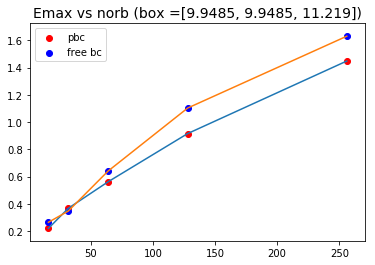

In [24]:
plt.plot(N,E)
plt.scatter(N,E, color='r',label='pbc')
plt.plot(N,Efree)
plt.scatter(N,Efree, color='b',label='free bc')
plt.legend()
plt.title('Emax vs norb (box ='+str(N2data[0].log['Sizes of the simulation domain']['Angstroem'])+')',fontsize=14)
plt.show()

### Expansion of the perturbed KS orbitals

We compute the projection of the KS orbitals for the ground state of the system under the action of a static electric field on the orbitals (both occupied and empty) computed here. We consider a field of norm $1e-2$ both in the $z$ and $x$ directions.

In [13]:
n = 256
Ex_psip = '../data-Ex_1em2_rmult_7/'
Ez_psip = '../data-Ez_1em2_rmult_7/'
inpEx={'dft':
       {'norbv': -n,
        'inputpsiid': 2,
        'output_wf': 0,
        'itermax_virt' : 1},
       'tddft':{'decompose_perturbation': Ex_psip}}
inpEz={'dft':
       {'norbv': -n,
        'inputpsiid': 2,
        'output_wf': 0,
        'itermax_virt' : 1},
       'tddft':{'decompose_perturbation': Ez_psip}}
ExInpname = 'N2Ex-pbc_rmult7_norb'+str(n)
EzInpname = 'N2Ez-pbc_rmult7_norb'+str(n)

Yaml.dump(inpEz,inputpath + EzInpname + '.yaml')
Yaml.dump(inpEx,inputpath + ExInpname + '.yaml')

Now we import the result and perform the data analysis

In [14]:
logs = !ls testfiles/N2maxEngVorb/log-pbc/log-N2E*
print(logs)
N2data=[lf.Logfile(l) for l in logs]

['testfiles/N2maxEngVorb/log-pbc/log-N2Ex-pbc_rmult7_norb256.yaml', 'testfiles/N2maxEngVorb/log-pbc/log-N2Ez-pbc_rmult7_norb256.yaml']


We define the  following list of arrays (the first element correponds to Ex, the second to Ez): 

In [15]:
coeff_occ = [n.log['<psi_i|psi_j>'] for n in N2data]
coeff_occ=np.double(np.array(coeff_occ))

coeff_vrt = [n.log['<psiv_i|D psi_j>'] for n in N2data]
coeff_vrt=np.double(np.array(coeff_vrt))

The element [i,j] of coeff_occ[n] contains the projection of the j-th perturbed (occupied) orbital on the i-th unperturbed (occupied) one. In the same way but with the opposite convention, coeff_vrt contains the projection of the i-th perturbed (occupied) orbital on the j-th unperturbed empty one

We also read other useful quantities (we define common quantities for both Ex and Ez since the orbitals are the same)

In [16]:
n_occ,n_vrt = coeff_vrt[0].shape
print 'no_occ',n_occ, 'n_vrt', n_vrt
en = N2data[0].evals[0][0]
e_v=[]
e_o=[]
for o in range(n_occ):
    e_o.append(en[o])
for v in range(n_occ,n_occ+n_vrt):
    e_v.append(en[v])


no_occ 5 n_vrt 256


In [17]:
coeff_occ[0]

array([[  1.03040663e+00,  -3.14571256e-04,  -4.95647325e-03,
          3.77547085e-04,  -5.04988521e-04],
       [  3.14660877e-04,   1.03039196e+00,  -1.13699659e-05,
          2.98960997e-07,   1.97737393e-04],
       [ -3.25231785e-03,   1.49440090e-06,  -7.27457142e-01,
         -7.28370642e-01,  -3.70039793e-02],
       [ -3.78603556e-03,   1.43565169e-06,  -7.27385593e-01,
          7.28437714e-01,  -3.69539281e-02],
       [ -3.36317853e-04,  -1.97690924e-04,  -5.22943826e-02,
         -3.21259805e-05,   1.02874894e+00]])

In [18]:
psiprimeEx=np.array([ 0.0 for i in range(n_occ)])
psiprimeEz=np.array([ 0.0 for i in range(n_occ)])
for o in range(n_occ):
    psiprimeEx += coeff_occ[0][o]**2
    psiprimeEz += coeff_occ[1][o]**2
# we quantify the magnitude of the missing part
#psiprimeEx = 1.0-psiprimeEx
#psiprimeEz = 1.0-psiprimeEz
psiprimeEx

array([ 1.06176295,  1.06170773,  1.06104296,  1.06114544,  1.06105957])

We observe that the norm of the projected state is greater the one. This means that there is some problem in projecting the states of a periodic system in the ones of a system with free boundary condition. So this type of analysis cannot be performed here.